In [1]:
%pip install --upgrade pip wheel setuptools
%pip install pandas geopandas shapely pyproj folium tqdm pyogrio rtree


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import glob
import warnings
from pathlib import Path

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
#from shapely.ops import nearest_points
from tqdm import tqdm

warnings.filterwarnings("ignore", category=UserWarning)

# ----------------------------
# CONFIG
# ----------------------------
SSUSA_CSV = r"C:\Users\Bio Surplus\Downloads\CS8903\CS8903_HAAG_Spatial_Camera_Trap_Summer2025\ProximityAnalysis\species_list_5km.csv"
IUCN_SINGLE_FILE = r"C:\Users\Bio Surplus\Downloads\CS8903\IUCN_Data\MAMMALS_TERRESTRIAL_ONLY.shp"
IUCN_DIR = None                   
OUTPUT_DIR = "outputs"

# Column names in your SSUSA file (rename here if needed)
SSUSA_LAT_COL = "Latitude"
SSUSA_LON_COL = "Longitude"
SSUSA_SPECIES_COL = "species"   # could be 'scientific_name' in your file
SSUSA_SITE_COL = "Array_Name"      # optional; if unavailable, we'll synthesize from lat/lon

# Name matching file from Neelima (optional now; plug in later)
NEELIMA_NAMES = None  # e.g., "data/names/neelima_matched_names.csv"
NEELIMA_SSUSA_NAME_COL = "ssusa_name"
NEELIMA_IUCN_NAME_COL = "iucn_name"

# IUCN species-name column (change to what your file(s) use)
IUCN_SPECIES_COL = "sci_name"  # common in IUCN datasets; sometimes 'scientificName'

# For distance calc, project to a metric CRS (World Mercator or equal-area)
METRIC_CRS = "EPSG:3857"   # good enough for nearest-distance QA (meters)
WGS84 = "EPSG:4326"


# ----------------------------
# HELPERS
# ----------------------------
def _canon_name(s):
    return (s.astype(str)
              .str.strip()
              .str.replace(r"\s+", " ", regex=True)
              .str.lower())

def ensure_output_dir(path):
    Path(path).mkdir(parents=True, exist_ok=True)

def load_ssusa_points(csv_path):
    df = pd.read_csv(csv_path)

    # If there's no 'species' column, this is a wide site×species matrix → melt to long
    if SSUSA_SPECIES_COL not in df.columns:
        id_vars_candidates = [SSUSA_SITE_COL, SSUSA_LAT_COL, SSUSA_LON_COL, "Year", "Radius"]
        id_vars = [c for c in id_vars_candidates if c in df.columns]
        id_vars = list(dict.fromkeys(id_vars))  # <-- dedupe to avoid duplicates
        value_vars = [c for c in df.columns if c not in id_vars]

        # Melt and keep only presences (value > 0)
        long_df = df.melt(id_vars=id_vars, value_vars=value_vars,
                          var_name=SSUSA_SPECIES_COL, value_name="presence")
        long_df["presence"] = pd.to_numeric(long_df["presence"], errors="coerce").fillna(0)
        long_df = long_df[long_df["presence"] > 0].drop(columns=["presence"])

        df = long_df

    # Sanity: required columns
    required = [SSUSA_LAT_COL, SSUSA_LON_COL, SSUSA_SPECIES_COL]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required columns after processing SSUSA CSV: {missing}")

    # Ensure a site_id exists
    if SSUSA_SITE_COL not in df.columns:
        df[SSUSA_SITE_COL] = (df[SSUSA_LAT_COL].round(5).astype(str) + "," +
                              df[SSUSA_LON_COL].round(5).astype(str))

    # Geometry
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df[SSUSA_LON_COL], df[SSUSA_LAT_COL]),
        crs=WGS84
    )
    return gdf


def load_neelima_mapping(path):
    if path is None or not os.path.exists(path):
        return None
    m = pd.read_csv(path)
    # standardize
    m[NEELIMA_SSUSA_NAME_COL] = m[NEELIMA_SSUSA_NAME_COL].str.strip()
    m[NEELIMA_IUCN_NAME_COL] = m[NEELIMA_IUCN_NAME_COL].str.strip()
    return m[[NEELIMA_SSUSA_NAME_COL, NEELIMA_IUCN_NAME_COL]].dropna()

def harmonize_names(ssusa_gdf, mapping_df):
    ssusa = ssusa_gdf.copy()
    ssusa["species_raw"] = ssusa[SSUSA_SPECIES_COL].astype(str).str.strip()
    if mapping_df is None:
        ssusa["species_iucn_key"] = ssusa["species_raw"]
    else:
        ssusa = ssusa.merge(
            mapping_df,
            left_on="species_raw",
            right_on=NEELIMA_SSUSA_NAME_COL,
            how="left"
        )
        ssusa["species_iucn_key"] = ssusa[NEELIMA_IUCN_NAME_COL].fillna(ssusa["species_raw"])
        # Clean up
        drop_cols = [c for c in [NEELIMA_SSUSA_NAME_COL, NEELIMA_IUCN_NAME_COL] if c in ssusa.columns]
        ssusa = ssusa.drop(columns=drop_cols)
    return ssusa

def load_iucn_polygons(single_file=None, directory=None):
    """
    Returns a GeoDataFrame with at least [IUCN_SPECIES_COL, geometry].
    Supports one big file or a folder of many files.
    """
    if single_file and os.path.exists(single_file):
        gdf = gpd.read_file(single_file)
        # keep only necessary columns if huge
        keep = [IUCN_SPECIES_COL, "geometry"]
        cols = [c for c in keep if c in gdf.columns] + [c for c in gdf.columns if c not in keep]
        gdf = gdf[cols]
        return gdf.to_crs(WGS84)

    # folder mode
    all_paths = []
    for ext in ("*.gpkg", "*.geojson", "*.json", "*.shp"):
        all_paths.extend(glob.glob(os.path.join(directory, ext)))
    if not all_paths:
        raise FileNotFoundError("No IUCN range files found.")

    frames = []
    for p in tqdm(all_paths, desc="Loading IUCN files"):
        try:
            g = gpd.read_file(p)
            if IUCN_SPECIES_COL not in g.columns:
                # try to guess a species column
                for candidate in ["binomial", "scientificName", "species", "BINOMIAL"]:
                    if candidate in g.columns:
                        g = g.rename(columns={candidate: IUCN_SPECIES_COL})
                        break
            if IUCN_SPECIES_COL not in g.columns:
                # stash filename as best-effort key
                g[IUCN_SPECIES_COL] = Path(p).stem
            frames.append(g[[IUCN_SPECIES_COL, "geometry"]])
        except Exception as e:
            print(f"Warning: failed to read {p}: {e}")
    if not frames:
        raise RuntimeError("IUCN folder contained no readable geodata.")
    gdf = pd.concat(frames, ignore_index=True)
    gdf = gpd.GeoDataFrame(gdf, geometry="geometry", crs=gdf.crs or WGS84).to_crs(WGS84)
    return gdf

def summarize_per_species(obs_df, inside_col="inside_iucn"):
    grp = obs_df.groupby("species_iucn_key", dropna=False)
    records = []
    for k, sub in grp:
        total = len(sub)
        inside = int(sub[inside_col].sum())
        outside = total - inside
        uniq_sites_inside = sub.loc[sub[inside_col], "site_id"].nunique()
        uniq_sites_out = sub.loc[~sub[inside_col], "site_id"].nunique()
        records.append({
            "species_iucn_key": k,
            "ssusa_total_obs": total,
            "inside_count": inside,
            "outside_count": outside,
            "pct_inside": round(inside / total * 100, 2) if total > 0 else 0.0,
            "unique_sites_inside": uniq_sites_inside,
            "unique_sites_outside": uniq_sites_out
        })
    return pd.DataFrame(records).sort_values(["pct_inside", "ssusa_total_obs"], ascending=[True, False])

def build_quick_map(obs_gdf, out_html, max_points=5000):
    """
    Simple Folium map for QA (random sample if very large).
    """
    try:
        import folium
    except ImportError:
        print("folium not installed; skipping map.")
        return
    m = folium.Map(location=[39, -98], zoom_start=4, tiles="cartodbpositron")
    df = obs_gdf.sample(min(len(obs_gdf), max_points), random_state=42)
    for _, r in df.iterrows():
        col = "green" if r["inside_iucn"] else "red"
        folium.CircleMarker(
            location=[r.geometry.y, r.geometry.x],
            radius=3,
            color=col,
            fill=True,
            fill_opacity=0.7,
            tooltip=f"{r.get('species_raw','?')} | inside: {r['inside_iucn']}"
        ).add_to(m)
    m.save(out_html)

# ----------------------------
# MAIN
# ----------------------------
def main():
    ensure_output_dir(OUTPUT_DIR)

    # 1) Load SSUSA points
    ssusa = load_ssusa_points(SSUSA_CSV)
    ssusa = ssusa.rename(columns={SSUSA_SITE_COL: "site_id"})
    # 2) Harmonize names (now or with Neelima's mapping later)
    mapping = load_neelima_mapping(NEELIMA_NAMES)

    ssusa = harmonize_names(ssusa, mapping)
    ssusa["species_iucn_key"] = _canon_name(ssusa["species_iucn_key"])
    
    # === Standardize SSUSA scientific names to match IUCN ===
    RENAME_TO_IUCN = {
        # Common name → old -> new (apply on canonical key)
        # long-tailed weasel
        "mustela frenata": "neogale frenata",
        # southern red-backed vole
        "myodes gapperi": "clethrionomys gapperi",
        # american mink
        "neovison vison": "neogale vison",
        # fisher
        "pekania pennanti": "martes pennanti",
    }
    ssusa["species_iucn_key"] = ssusa["species_iucn_key"].replace(RENAME_TO_IUCN)

    # === Exclude species (domestic/commensal + non-native) ===
    EXCLUDE_SPECIES = {
        # Domestic / commensals
        "canis familiaris",     # domestic dog
        "felis catus",          # domestic cat
        "bos taurus",           # domestic cattle
        "equus caballus",       # domestic horse
        "ovis aries",           # domestic sheep
        "sus scrofa",           # domestic/wild pig (drop per request)
        "capra aegagrus hircus",# domestic goat
        "equus asinus",         # domestic donkey
        "rattus norvegicus",    # brown rat
        "rattus rattus",        # house (black) rat
        "mus musculus",         # house mouse
    
        # Non-native to drop
        "boselaphus tragocamelus",  # nilgai
        "lama glama",               # llama
        "lariscus insignis",        # three-striped ground squirrel
        "oryx gazella",             # gemsbok
        "urva javanica",            # javan mongoose
    }

    # Log and remove by the canonical key (covers capitalization/whitespace)
    excluded = ssusa[ssusa["species_iucn_key"].isin(EXCLUDE_SPECIES)]
    if len(excluded):
        Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
        (excluded.groupby("species_iucn_key")
                 .size()
                 .reset_index(name="excluded_records")
                 .to_csv(os.path.join(OUTPUT_DIR, "excluded_removed_counts.csv"), index=False))
    
    ssusa = ssusa[~ssusa["species_iucn_key"].isin(EXCLUDE_SPECIES)]
    print(f"Excluded {len(excluded)} records (domestic/non-native); proceeding with {len(ssusa)} SSUSA records.")


    # 3) Load IUCN polygons
    iucn = load_iucn_polygons(
        single_file=IUCN_SINGLE_FILE if os.path.exists(IUCN_SINGLE_FILE) else None,
        directory=IUCN_DIR if IUCN_DIR and os.path.exists(IUCN_DIR) else None
    )

    # ensure the species-name column exists (handles sci_name/binomial/etc.) — use a local var
    species_col = IUCN_SPECIES_COL
    if species_col not in iucn.columns:
        for c in ("sci_name", "binomial", "BINOMIAL", "scientificName", "species"):
            if c in iucn.columns:
                species_col = c
                break
    assert species_col in iucn.columns, "Couldn't find a species-name column in the IUCN file."
    
    # standardize iucn species col
    iucn[species_col] = iucn[species_col].astype(str).str.strip()

    iucn["species_key"] = _canon_name(iucn[species_col])



    # 4) Split SSUSA into those with an IUCN polygon available vs not (by species key)
    # OLD
    # have_iucn = ssusa["species_iucn_key"].isin(iucn[species_col].unique())
    # NEW
    have_iucn = ssusa["species_iucn_key"].isin(iucn["species_key"].unique())
    ssusa["has_iucn_polygon"] = have_iucn

    # 5) Spatial compare: points-in-polygons, species-matched for speed
    results = []
    missing = []
    for sp, sub in tqdm(ssusa.groupby("species_iucn_key"), total=ssusa["species_iucn_key"].nunique(), desc="Comparing"):
        g_sub = gpd.GeoDataFrame(sub.copy(), geometry="geometry", crs=WGS84)
        poly = iucn[iucn["species_key"] == sp]
        if poly.empty:
            missing.append(sp)
            # mark all as outside and no distance (we can fill later)
            g_sub["inside_iucn"] = False
            g_sub["distance_m_to_iucn"] = None
            results.append(g_sub)
            continue

        # within test (fast)
        inside = gpd.sjoin(g_sub, poly[["geometry"]], predicate="within", how="left")
        g_sub["inside_iucn"] = ~inside.index_right.isna()

        # For outside points, compute nearest distance to polygon boundary (meters)
        if (~g_sub["inside_iucn"]).any():
            # project both to metric CRS for distance
            g_sub_m = g_sub.to_crs(METRIC_CRS)
            poly_m = poly.to_crs(METRIC_CRS)
            union_poly = poly_m.unary_union

            dists = []
            for geom in g_sub_m.geometry:
                if geom is None:
                    dists.append(None)
                else:
                    dists.append(geom.distance(union_poly))
            g_sub["distance_m_to_iucn"] = dists
        else:
            g_sub["distance_m_to_iucn"] = 0.0

        results.append(g_sub)

    obs = pd.concat(results, ignore_index=True)

    # 6) Summaries
    species_summary = summarize_per_species(obs, inside_col="inside_iucn")

    # 7) Non-overlap sites (any species outside at a site)
    non_overlap_sites = (obs.loc[~obs["inside_iucn"], ["site_id", "species_raw", "species_iucn_key",
                                                   SSUSA_LAT_COL, SSUSA_LON_COL, "distance_m_to_iucn"]]
                       .sort_values(["site_id", "species_raw"]))

    # 8) Missing IUCN polygons list
    missing_unique = sorted(set(missing))
    missing_df = pd.DataFrame({"species_iucn_key": missing_unique})

    # 9) Write outputs
    obs_out = obs.drop(columns=["geometry"])
    obs_out.to_csv(os.path.join(OUTPUT_DIR, "obs_with_overlap.csv"), index=False)
    species_summary.to_csv(os.path.join(OUTPUT_DIR, "species_summary.csv"), index=False)
    non_overlap_sites.to_csv(os.path.join(OUTPUT_DIR, "non_overlap_sites.csv"), index=False)
    missing_df.to_csv(os.path.join(OUTPUT_DIR, "missing_iucn_polygons.csv"), index=False)


    # -------------------------------------------------------
    # Reverse analysis: IUCN polygons vs SSUSA sampling points
    # -------------------------------------------------------
    print("Calculating IUCN polygon coverage by SSUSA detections...")

    print("Clipping IUCN polygons to U.S. boundaries...")

    # Download or load a simple USA boundary shapefile (only once)
    # You can use Natural Earth data directly:
    usa_url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
    usa = gpd.read_file(usa_url)
    
    # Keep only the United States polygon
    usa = usa[usa["ADMIN"] == "United States of America"].to_crs(iucn.crs)
    
    # Intersect IUCN polygons with USA boundary to keep only U.S. portions
    iucn_us = gpd.overlay(iucn, usa, how="intersection")
    
    # Replace the original IUCN dataframe with the U.S.-clipped version
    iucn = iucn_us

    # Project both datasets to metric CRS for area calculations (in km²)
    ssusa_m = ssusa.to_crs(METRIC_CRS)
    iucn_m = iucn.to_crs(METRIC_CRS)

    records = []

    # Filter IUCN polygons to species actually observed in SSUSA
    valid_species = set(ssusa["species_iucn_key"].unique())
    iucn_m = iucn_m[iucn_m["species_key"].isin(valid_species)].copy()

    
    # Loop through each IUCN species polygon
    for sp, poly in tqdm(iucn_m.groupby("species_key"), total=iucn_m["species_key"].nunique(), desc="IUCN→SSUSA"):
        # Select SSUSA detections for that species
        pts = ssusa_m[ssusa_m["species_iucn_key"] == sp]

        # Skip species not detected by SSUSA
        if len(pts) == 0:
            records.append({
                "species_key": sp,
                "iucn_area_km2": poly.area.sum() / 1e6,
                "ssusa_covered_area_km2": 0.0,
                "pct_area_sampled": 0.0,
                "n_ssusa_detections": 0
            })
            continue

        # Buffer each SSUSA detection to represent a 5-km observation radius
        buffer_union = pts.buffer(5000).unary_union

        # Intersect buffered detections with IUCN polygons
        try:
            iucn_union = poly.unary_union
            overlap_area = iucn_union.intersection(buffer_union).area / 1e6  # km²
            total_area = iucn_union.area / 1e6
            pct = (overlap_area / total_area) * 100 if total_area > 0 else 0
        except Exception as e:
            overlap_area = 0.0
            pct = 0.0
            print(f"Warning: intersection failed for {sp}: {e}")

        records.append({
            "species_key": sp,
            "iucn_area_km2": total_area,
            "ssusa_covered_area_km2": overlap_area,
            "pct_area_sampled": pct,
            "n_ssusa_detections": len(pts)
        })

    # Create DataFrame
    iucn_cov = pd.DataFrame(records)

    # Save results
    iucn_cov.to_csv(os.path.join(OUTPUT_DIR, "iucn_coverage_summary.csv"), index=False)

    # Quick console summary
    mean_cov = iucn_cov["pct_area_sampled"].mean()
    n_zero = (iucn_cov["pct_area_sampled"] == 0).sum()
    n_species = len(iucn_cov)

    print("---- IUCN → SSUSA Coverage Summary ----")
    print(f"Total IUCN species polygons analyzed: {n_species}")
    print(f"Average percent of IUCN range covered by SSUSA detections: {mean_cov:.2f}%")
    print(f"Species with zero overlap (no SSUSA detections): {n_zero}")
    print("---------------------------------------")
    #End of Reverse analysis: IUCN polygons vs SSUSA sampling points
    #----------------------------------------------------------------
    
    # 10) Quick map (optional)
    try:
        build_quick_map(gpd.GeoDataFrame(obs, geometry="geometry", crs=WGS84),
                        os.path.join(OUTPUT_DIR, "quick_map.html"),
                        max_points=5000)
    except Exception as e:
        print(f"Map skipped: {e}")

    # 11) Console summary
    total_obs = len(obs)
    no_iucn_obs = int((~obs["has_iucn_polygon"]).sum())
    inside = int(obs["inside_iucn"].sum())
    outside = total_obs - inside
    print("---- SUMMARY ----")
    print(f"Total SSUSA observations: {total_obs}")
    print(f"Observations with no IUCN polygon available: {no_iucn_obs}")
    print(f"Inside IUCN polygons: {inside}")
    print(f"Outside IUCN polygons: {outside}")
    print(f"Species with zero overlap (but present in SSUSA):")
    zero_overlap = species_summary.loc[species_summary["inside_count"] == 0, "species_iucn_key"].tolist()
    print(zero_overlap[:25], "..." if len(zero_overlap) > 25 else "")

if __name__ == "__main__":
    main()


Excluded 863 records (domestic/non-native); proceeding with 5918 SSUSA records.


Comparing:   0%|          | 0/113 [00:00<?, ?it/s]C:\Users\Bio Surplus\AppData\Local\Temp\ipykernel_11720\3558096615.py:320: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  union_poly = poly_m.unary_union
Comparing:   1%|          | 1/113 [00:02<05:00,  2.68s/it]C:\Users\Bio Surplus\AppData\Local\Temp\ipykernel_11720\3558096615.py:320: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  union_poly = poly_m.unary_union
C:\Users\Bio Surplus\AppData\Local\Temp\ipykernel_11720\3558096615.py:320: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  union_poly = poly_m.unary_union
Comparing:   4%|▎         | 4/113 [00:02<00:59,  1.84it/s]C:\Users\Bio Surplus\AppData\Local\Temp\ipykernel_11720\3558096615.py:320: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  union_poly = poly_m.unary_

Calculating IUCN polygon coverage by SSUSA detections...
Clipping IUCN polygons to U.S. boundaries...


IUCN→SSUSA:   0%|          | 0/107 [00:00<?, ?it/s]C:\Users\Bio Surplus\AppData\Local\Temp\ipykernel_11720\3558096615.py:405: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_union = pts.buffer(5000).unary_union
C:\Users\Bio Surplus\AppData\Local\Temp\ipykernel_11720\3558096615.py:409: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  iucn_union = poly.unary_union
IUCN→SSUSA:   1%|          | 1/107 [00:00<00:48,  2.17it/s]C:\Users\Bio Surplus\AppData\Local\Temp\ipykernel_11720\3558096615.py:405: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_union = pts.buffer(5000).unary_union
C:\Users\Bio Surplus\AppData\Local\Temp\ipykernel_11720\3558096615.py:409: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  iucn_union = poly.unary_union
C:\Users\Bio Surplus\AppData\L

---- IUCN → SSUSA Coverage Summary ----
Total IUCN species polygons analyzed: 107
Average percent of IUCN range covered by SSUSA detections: 0.09%
Species with zero overlap (no SSUSA detections): 10
---------------------------------------
---- SUMMARY ----
Total SSUSA observations: 5918
Observations with no IUCN polygon available: 143
Inside IUCN polygons: 5357
Outside IUCN polygons: 561
Species with zero overlap (but present in SSUSA):
['neogale vison', 'lontra canadensis', 'castor canadensis', 'bison bison', 'ondatra zibethicus', 'sus scrofa scrofa', 'neotamias sonomae', 'brachylagus idahoensis', 'neotamias merriami', 'neotamias obscurus', 'neotamias panamintinus', 'neotamias ruficaudus', 'neotamias umbrinus', 'ovis canadensis', 'urocitellus armatus', 'zalophus californianus'] 


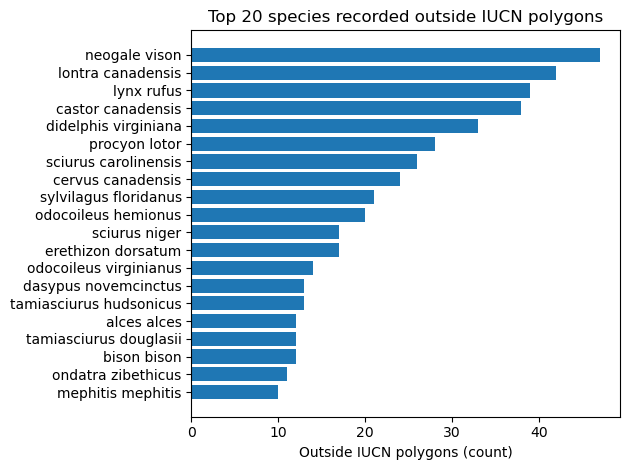

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

species_summary = pd.read_csv("outputs/species_summary.csv")

top_outside = (species_summary
               .assign(outside_pct=lambda d: 100*d['outside_count']/d['ssusa_total_obs'])
               .sort_values(['outside_count','ssusa_total_obs'], ascending=[False, False])
               .head(20))

plt.figure()
plt.barh(top_outside['species_iucn_key'][::-1], top_outside['outside_count'][::-1])
plt.xlabel("Outside IUCN polygons (count)")
plt.title("Top 20 species recorded outside IUCN polygons")
plt.tight_layout()
plt.show()


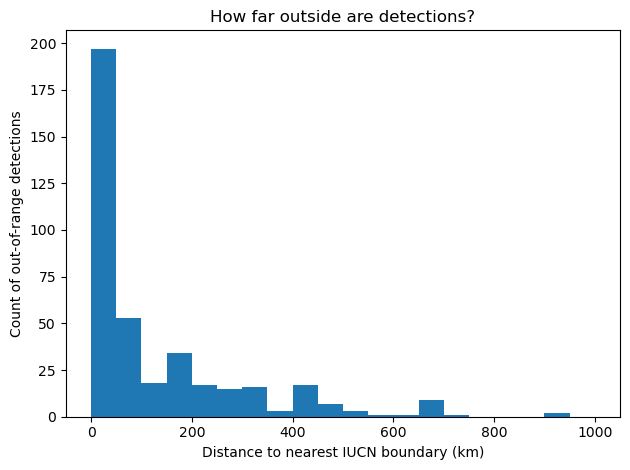

In [3]:
import numpy as np

obs = pd.read_csv("outputs/obs_with_overlap.csv")
dist = obs.loc[~obs['inside_iucn'] & obs['distance_m_to_iucn'].notna(), 'distance_m_to_iucn'] / 1000.0

plt.figure()
plt.hist(dist, bins=np.arange(0, 1000+50, 50))  # 0–1000 km in 50 km bins
plt.xlabel("Distance to nearest IUCN boundary (km)")
plt.ylabel("Count of out-of-range detections")
plt.title("How far outside are detections?")
plt.tight_layout()
plt.show()


In [4]:
import pandas as pd, geopandas as gpd, folium

obs_df = pd.read_csv("outputs/obs_with_overlap.csv")

# robust bool conversion
obs_df["inside_iucn"] = obs_df["inside_iucn"].astype(str).str.lower().map(
    {"true": True, "false": False, "1": True, "0": False}
)

obs_g = gpd.GeoDataFrame(
    obs_df,
    geometry=gpd.points_from_xy(obs_df[SSUSA_LON_COL], obs_df[SSUSA_LAT_COL]),
    crs="EPSG:4326"
)

m = folium.Map(location=[39, -98], zoom_start=4, tiles="cartodbpositron")
for _, r in obs_g[~obs_g["inside_iucn"]].iterrows():
    folium.CircleMarker([r.geometry.y, r.geometry.x], radius=3, color="red", fill=True).add_to(m)

m.save("outputs/outside_only_map.html")


In [5]:
species_summary = pd.read_csv("outputs/species_summary.csv")
missing = pd.read_csv("outputs/missing_iucn_polygons.csv")

zero = species_summary[species_summary['inside_count']==0].copy()
zero['reason'] = np.where(zero['species_iucn_key'].isin(missing['species_iucn_key']),
                          'No IUCN polygon matched',
                          'Polygon exists but all detections outside')

zero.sort_values(['reason','ssusa_total_obs'], ascending=[True, False]).head(30)


,species_iucn_key,ssusa_total_obs,inside_count,outside_count,pct_inside,unique_sites_inside,unique_sites_outside,reason
0,neogale vison,47,0,47,0.0,0,33,No IUCN polygon matched
1,lontra canadensis,42,0,42,0.0,0,30,No IUCN polygon matched
2,castor canadensis,38,0,38,0.0,0,23,No IUCN polygon matched
4,ondatra zibethicus,11,0,11,0.0,0,6,No IUCN polygon matched
5,sus scrofa scrofa,4,0,4,0.0,0,4,No IUCN polygon matched
15,zalophus californianus,1,0,1,0.0,0,1,No IUCN polygon matched
3,bison bison,12,0,12,0.0,0,5,Polygon exists but all detections outside
6,neotamias sonomae,2,0,2,0.0,0,1,Polygon exists but all detections outside
7,brachylagus idahoensis,1,0,1,0.0,0,1,Polygon exists but all detections outside
8,neotamias merriami,1,0,1,0.0,0,1,Polygon exists but all detections outside


In [31]:
def to_binomial(s):
    return " ".join(str(s).split()[:2])

# Preview how many SSUSA names are subspecies
obs = pd.read_csv("outputs/obs_with_overlap.csv")
print("Unique SSUSA names:", obs['species_raw'].nunique())
print("Unique binomials  :", obs['species_raw'].apply(to_binomial).nunique())


Unique SSUSA names: 120
Unique binomials  : 119


In [6]:
import pandas as pd

species_summary = pd.read_csv("outputs/species_summary.csv")
missing = pd.read_csv("outputs/missing_iucn_polygons.csv")

zero = species_summary[species_summary["inside_count"] == 0].copy()
zero["reason"] = zero["species_iucn_key"].isin(missing["species_iucn_key"]).map(
    {True: "No IUCN polygon matched", False: "Polygon exists but all detections outside"}
)

cols = ["species_iucn_key", "ssusa_total_obs", "outside_count",
        "unique_sites_outside", "reason"]
zero = zero[cols].sort_values(["reason", "outside_count", "ssusa_total_obs"], ascending=[True, False, False])

zero.to_csv("outputs/zero_overlap_explained.csv", index=False)
print("Wrote outputs/zero_overlap_explained.csv")


Wrote outputs/zero_overlap_explained.csv


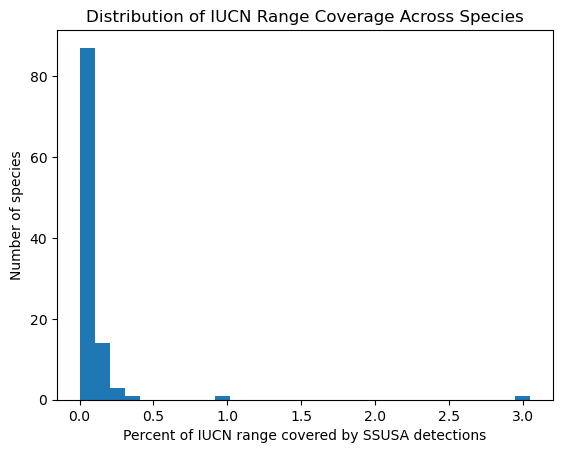

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("outputs/iucn_coverage_summary.csv")
plt.hist(df["pct_area_sampled"], bins=30)
plt.xlabel("Percent of IUCN range covered by SSUSA detections")
plt.ylabel("Number of species")
plt.title("Distribution of IUCN Range Coverage Across Species")
plt.show()


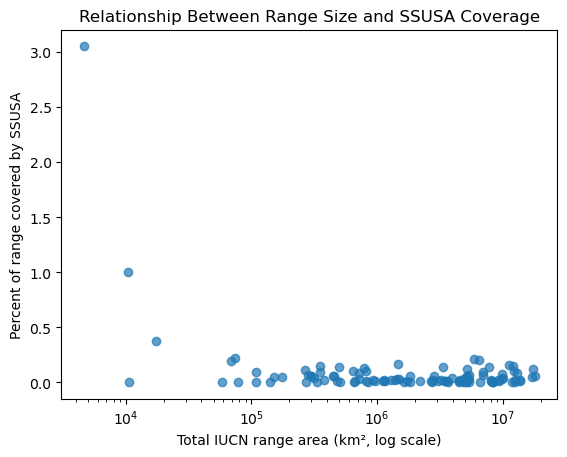

In [13]:
plt.scatter(df["iucn_area_km2"], df["pct_area_sampled"], alpha=0.7)
plt.xscale("log")
plt.xlabel("Total IUCN range area (km², log scale)")
plt.ylabel("Percent of range covered by SSUSA")
plt.title("Relationship Between Range Size and SSUSA Coverage")
plt.show()

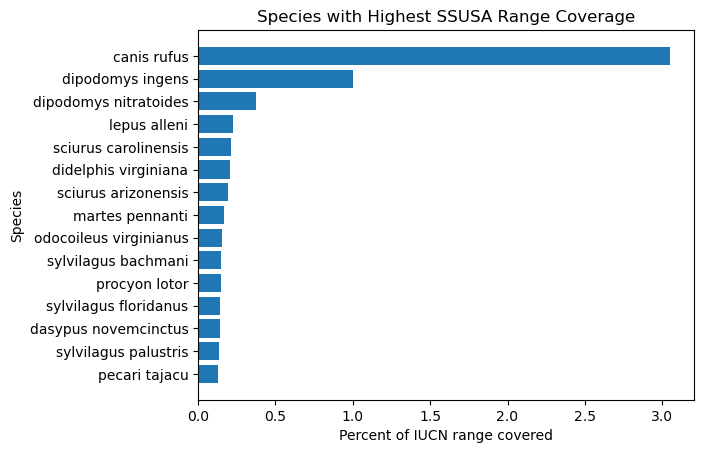

In [14]:
top = df.sort_values("pct_area_sampled", ascending=False).head(15)
plt.barh(top["species_key"], top["pct_area_sampled"])
plt.xlabel("Percent of IUCN range covered")
plt.ylabel("Species")
plt.title("Species with Highest SSUSA Range Coverage")
plt.gca().invert_yaxis()
plt.show()

In [25]:
# -------------------------------------------------------
# SSUSA outside vs. IUCN (U.S.-only) interactive map
# - Legend
# - Per-species layers for polygons and points
# - Search, Fullscreen, MiniMap, Measure
# -------------------------------------------------------
import os
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import Fullscreen, MiniMap, MeasureControl, Search

#Paths (edit if needed)
NON_OVERLAP_CSV = r"C:\Users\Bio Surplus\Downloads\CS8903\outputs\non_overlap_sites.csv"
IUCN_FILE       = r"C:\Users\Bio Surplus\Downloads\CS8903\IUCN_Data\MAMMALS_TERRESTRIAL_ONLY.shp"
OUTPUT_HTML     = r"C:\Users\Bio Surplus\Downloads\CS8903\SSUSA_outside_US_layercontrol_with_legend.html"

#Column names
LAT_COL = "Latitude"
LON_COL = "Longitude"
SPECIES_COL_RAW = "species_raw"
SPECIES_COL_KEY = "species_iucn_key"
DIST_COL = "distance_m_to_iucn"
SITE_COL = "site_id"

#Load data
outside = pd.read_csv(NON_OVERLAP_CSV)
if LAT_COL not in outside.columns or LON_COL not in outside.columns:
    raise KeyError(f"Expected '{LAT_COL}' and '{LON_COL}' in {NON_OVERLAP_CSV}")

#Keep a species label column for display
species_label = SPECIES_COL_RAW if SPECIES_COL_RAW in outside.columns else SPECIES_COL_KEY
if species_label not in outside.columns:
    raise KeyError("Expected species column not found in non_overlap_sites.csv")

iucn = gpd.read_file(IUCN_FILE).to_crs("EPSG:4326")

#Clip IUCN polygons to the US
print("Clipping IUCN polygons to the U.S. …")
usa_url = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
usa = gpd.read_file(usa_url)
usa = usa[usa["ADMIN"] == "United States of America"].to_crs(iucn.crs)
iucn = gpd.overlay(iucn, usa, how="intersection")

#Canonical species key on IUCN
def _canon(s):
    return (s.astype(str).str.strip().str.replace(r"\s+"," ", regex=True).str.lower())

sp_col = None
for c in ["sci_name", "BINOMIAL", "scientificName", "species"]:
    if c in iucn.columns:
        sp_col = c
        break
if sp_col is None:
    raise KeyError("Could not find a species column in the IUCN shapefile.")
iucn["species_key"] = _canon(iucn[sp_col])

#Map
center_lat = float(outside[LAT_COL].mean())
center_lon = float(outside[LON_COL].mean())
m = folium.Map(location=[center_lat, center_lon], zoom_start=5, tiles="CartoDB positron")

#Legend (bottom-left)
legend_html = """
<div style="
    position: fixed; 
    bottom: 20px; left: 20px; z-index: 9999; 
    background: white; padding: 10px 12px; 
    border: 1px solid #bbb; border-radius: 6px; 
    box-shadow: 0 1px 4px rgba(0,0,0,0.2);
    font-size: 13px;
">
  <div style="font-weight:600; margin-bottom:6px;">Legend</div>
  <div style="display:flex; align-items:center; margin-bottom:4px;">
    <span style="display:inline-block;width:12px;height:12px;border-radius:6px;background:#d7191c;margin-right:6px;"></span>
    <span>SSUSA detection outside IUCN polygon</span>
  </div>
  <div style="display:flex; align-items:center; margin-bottom:2px;">
    <span style="display:inline-block;width:14px;height:10px;background:#3186cc;opacity:0.25;border:1px solid #3186cc;margin-right:6px;"></span>
    <span>IUCN range (U.S. portion)</span>
  </div>
  <div style="display:flex; align-items:center; margin-top:6px;">
    <span style="display:inline-block;width:12px;height:12px;border-radius:6px;background:#ff7f00;margin-right:6px;"></span>
    <span>Selected species detections</span>
  </div>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

#All outside points as red dots
all_points_group = folium.FeatureGroup(name="All outside detections", show=True)
for _, r in outside.iterrows():
    lat = float(r[LAT_COL]); lon = float(r[LON_COL])
    sp = str(r[species_label])
    site = r.get(SITE_COL, "")
    dist_m = r.get(DIST_COL, None)
    tip = f"{sp}"
    if site: tip += f" | site: {site}"
    if pd.notna(dist_m):
        try:
            tip += f" | {float(dist_m):.0f} m to IUCN"
        except:
            pass
    folium.CircleMarker(
        location=[lat, lon],
        radius=3,
        color="#d7191c",
        fill=True,
        fill_opacity=0.9,
        tooltip=tip
    ).add_to(all_points_group)
all_points_group.add_to(m)

#Build per-species groups (polygons + points)
print("Adding species layers (polygons and points) …")
outside_gdf = gpd.GeoDataFrame(
    outside.copy(),
    geometry=gpd.points_from_xy(outside[LON_COL], outside[LAT_COL]),
    crs="EPSG:4326"
)
outside_gdf["species_key"] = _canon(outside_gdf[species_label])
iucn_groups = {sp: g for sp, g in iucn.groupby("species_key")}
species_present = sorted(outside_gdf["species_key"].dropna().unique())

for sp in species_present:
    if sp not in iucn_groups:
        continue

    poly_gdf = iucn_groups[sp].to_crs("EPSG:4326")
    pts_gdf = outside_gdf[outside_gdf["species_key"] == sp]

    #Polygon layer
    poly_group = folium.FeatureGroup(name=f"{sp} – IUCN range (U.S.)", show=False)
    folium.GeoJson(
        poly_gdf.__geo_interface__,
        style_function=lambda x: {"fillColor": "#3186cc", "color": "#3186cc",
                                  "weight": 1, "fillOpacity": 0.25},
        tooltip=f"{sp} (IUCN range)"
    ).add_to(poly_group)
    poly_group.add_to(m)

    #Species-specific points layer (orange)
    pts_group = folium.FeatureGroup(name=f"{sp} – detections", show=False)
    for _, r in pts_gdf.iterrows():
        tip = f"{sp}"
        site = r.get(SITE_COL, "")
        dist_m = r.get(DIST_COL, None)
        if site: tip += f" | site: {site}"
        if pd.notna(dist_m):
            try:
                tip += f" | {float(dist_m):.0f} m to IUCN"
            except:
                pass
        folium.CircleMarker(
            location=[r.geometry.y, r.geometry.x],
            radius=4,
            color="#ff7f00",
            fill=True,
            fill_opacity=0.9,
            tooltip=tip
        ).add_to(pts_group)
    pts_group.add_to(m)

#Useful plugins
Fullscreen(position="topleft").add_to(m)
MiniMap(toggle_display=True, position="bottomright").add_to(m)
MeasureControl(primary_length_unit='kilometers', secondary_length_unit='meters').add_to(m)

#Search plugin
pts_for_search = outside_gdf[[species_label, "geometry"]].copy()
pts_for_search.rename(columns={species_label: "species"}, inplace=True)
gj = folium.GeoJson(
    pts_for_search.to_json(),
    name="search_points",
    tooltip=folium.GeoJsonTooltip(fields=["species"], aliases=["Species"])
)
gj.add_to(m)
Search(
    layer=gj,
    search_label="species",
    placeholder="Search species…",
    collapsed=False
).add_to(m)

#Hide the default blue marker pin added by the search plugin
m.get_root().html.add_child(folium.Element("""
<script>
document.addEventListener('DOMContentLoaded', function() {
    if (window.map && window.map.on) {
        window.map.on('search:locationfound', function(e) {
            if (e.layer && e.layer._icon) {
                e.layer._icon.style.display = 'none'; // hide pin
            }
            if (e.layer && e.layer._shadow) {
                e.layer._shadow.style.display = 'none'; // hide pin shadow
            }
        });
    }
});
</script>
"""))


#Layer control
folium.LayerControl(collapsed=False).add_to(m)

#Save
m.save(OUTPUT_HTML)
print(f"Saved map: {OUTPUT_HTML}")


Clipping IUCN polygons to the U.S. …
Adding species layers (polygons and points) …
Saved map: C:\Users\Bio Surplus\Downloads\CS8903\SSUSA_outside_US_layercontrol_with_legend.html
